In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools
import models as m

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

import joblib
import seaborn as sns

[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
'''import data'''

df = pd.read_json(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/main_landscapes_all.json')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

In [7]:
'''remove small data points'''
df_trunc = mk.truncate(df, 300, save=True, printing =False)

'''remove french entries'''
df_all_clean = clean.detect_lang(df_trunc, "fr", printing =False)

'''remove spanish entries'''
df_all_clean = clean.detect_lang(df_trunc, "es", printing =False)

In [8]:
print(df.shape)
print(df.columns)

(603, 17)
Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forests',
       'tundra', 'conserved_areas', 'freshwaters', 'grasslands', 'desert',
       'marine', 'wetlands', 'human_altered_areas', 'no tag', 'category_1',
       'category_2', 'category_3', 'labels'],
      dtype='object')


,PIMS_ID,all_text_clean,all_text_clean_spacy,forests,tundra,conserved_areas,freshwaters,grasslands,desert,marine,wetlands,human_altered_areas,no tag,category_1,category_2,category_3,labels
0,1584,this programme will contribute to the protecti...,programme contribute protection biological div...,1,0,1,0,0,0,0,0,1,0,conserved_areas,forests,human_altered_areas,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
8,2762,madagascar is recognized as one of the greates...,madagascar recognize great mega diversity hots...,1,0,0,0,0,0,1,1,0,0,forests,marine,wetlands,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
11,3127,the project will develop and demonstrate the e...,project develop demonstrate efficacy adapt lan...,1,0,0,0,1,1,0,0,0,0,desert,forests,grasslands,"[1, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
13,3298,this project aims to promote biodiversity cons...,project aim promote biodiversity conservation ...,1,0,1,0,0,0,0,0,0,1,conserved_areas,forests,no tag,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1]"
16,3650,guineabissau straddles two major biomes coasta...,guinea bissau straddle major biome coastal mar...,1,0,0,1,0,0,0,1,0,0,forests,wetlands,freshwaters,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,6121,the objective of this project is the reduction...,objective project reduction emission greenhous...,1,0,0,0,0,0,0,0,0,1,forests,no tag,no tag,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
549,6143,the objective of this project is to strengthen...,objective project strengthen country technical...,1,0,0,0,0,0,0,0,0,1,forests,no tag,no tag,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
582,6248,the lion s share aims to help stem the rapid l...,lion share aim help stem rapid loss biodiversi...,1,0,0,0,0,0,0,0,0,1,forests,no tag,no tag,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
584,6252,to strengthen the integration of biodiversity ...,strengthen integration biodiversity conservati...,1,0,1,0,0,0,0,1,0,0,conserved_areas,forests,wetlands,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0]"


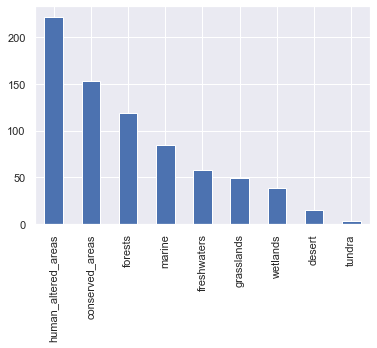

In [17]:
df[['forests',
       'tundra', 'conserved_areas', 'freshwaters', 'grasslands', 'desert',
       'marine', 'wetlands', 'human_altered_areas']].sum(axis=0).sort_values(ascending = False).plot.bar()

df_spec = df.loc[df['forests'] == 1]
df_spec

In [6]:
categories = ['forests','conserved_areas', 'freshwaters', 'grasslands', 'desert',
       'marine', 'wetlands', 'human_altered_areas']

remove = ['tundra',]

In [8]:
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}
    
for category in categories: 
    
    print('processing:', category)
    print('_____')
    #Creating the features (tf-idf weights) for the processed text
    texts = df_all_clean['all_text_clean'].astype('str')

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                       min_df = 2, 
                                       max_df = .95)
    
    X = tfidf_vectorizer.fit_transform(texts)     
    y = df_all_clean[category].values
    
    if len(category) > 50:
         shorter = category[0:50]
         #save vectorizer:
         filename = '../../models/tf_idf/landscape/'+shorter+'_'+'vectorizer.sav'
         joblib.dump(tfidf_vectorizer, filename)    
        
    else:
        #save vectorizer:
        filename = '../../models/tf_idf/landscape/'+category+'_'+'vectorizer.sav'
        joblib.dump(tfidf_vectorizer, filename)    
        
    #Dimenionality reduction. Only using the 100 best features er category
    lsa = TruncatedSVD(n_components=100, 
                       n_iter=10, 
                       random_state=3)
    X = lsa.fit_transform(X)

    if len(category) > 50:
        print('long')
        shorter = category[0:50]
        #save lsa model:
        filename = '../../models/tf_idf/landscape/'+shorter+'_'+'lsa.sav'
        joblib.dump(lsa, filename)
    else:
        #save vectorizer:
        filename = '../../models/tf_idf/landscape/'+category+'_'+'lsa.sav'
        joblib.dump(lsa, filename)  
    
    #Train test split with stratified sampling for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)
    
    m.model_score_df(model_dict, category, 'landscape', X_train, X_test, y_train, y_test)

processing: forests
_____
processing: conserved_areas
_____
processing: freshwaters
_____
processing: grasslands
_____
processing: desert
_____
processing: marine
_____
processing: wetlands
_____
processing: human_altered_areas
_____
human_altered_areas


train size: 395
test size: 170

Training accuracy: 0.97
Test accuracy: 0.935
f1 score: 0.6206896551724138


label_1    community
dtype: object

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       156
           1       0.60      0.64      0.62        14

    accuracy                           0.94       170
   macro avg       0.78      0.80      0.79       170
weighted avg       0.94      0.94      0.94       170



<AxesSubplot:xlabel='score', ylabel='features'>

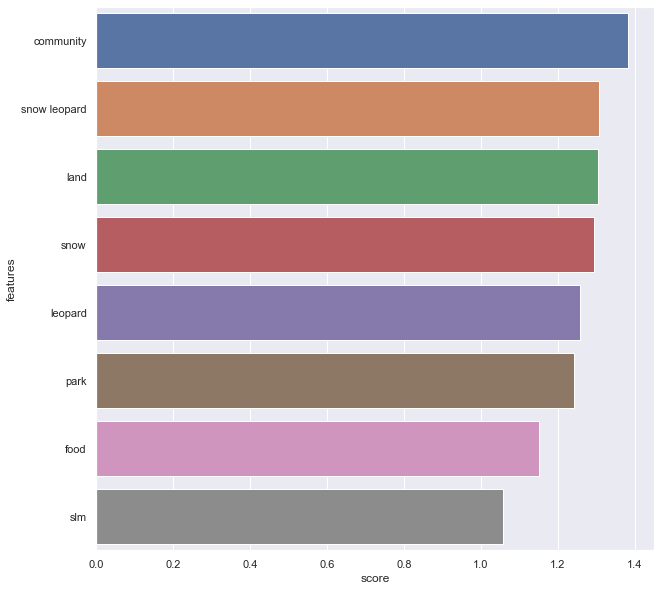

In [74]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])

X_train, X_test, y_train, y_test = train_test_split(df_all_clean['all_text_clean_spacy'],
                                                    df_all_clean['grasslands'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True, 
                                                    stratify = df_all_clean['human_altered_areas'].values)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"


'''print top features of category'''
# df_spec = df.loc[df['forests'] == 1]
# text = df_spec['all_text_clean_spacy']

# vect_cat = vectorizer.fit_transform(text)

# feature_array = np.array(vectorizer.get_feature_names())

# tfidf_sorting = np.argsort(vect_cat.toarray()).flatten()[::-1]
# n = 10
# top_n = feature_array[tfidf_sorting][:n]
# print(top_n)

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)



vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

# weight = 10

# position = vect.vocabulary_['urban']
# X_train[:, position] *= weight
# X_test[:, position] *= weight


clf = LogisticRegression(random_state = 3, class_weight = "balanced").fit(X_train, y_train)
print('')
print('Training accuracy:', clf.score(X_train, y_train).round(3))
print('Test accuracy:', clf.score(X_test, y_test).round(3))
y_hat = clf.predict(X_test)
print('f1 score:', f1_score(y_test, y_hat))
#top regressors 
#return top  regressors and convert to dataframe for visualisation:
df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
keywords = df_lambda.Keywords.iloc[0]

for key in keywords:

    df_regressors = df_regressors.append({'label': 'persistent_organic_pollutants', "features":key}, ignore_index=True)
    df_regressors['features'] = df_regressors['features'].astype(str)
    df_regressors['features'] = df_regressors['features'].str.replace('(','')
    df_regressors['features'] = df_regressors['features'].str.replace(')','')
    df_regressors['features'] = df_regressors['features'].str.replace("'",'')               

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
df_regressors['score'] = df_regressors['score'].astype(float)    
plt.figure(figsize=(10,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_all_clean['all_text_clean_spacy'],
                                                    df_all_clean['grasslands'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True, 
                                                    stratify = df_all_clean['human_altered_areas'].values)


'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)

vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train).toarray()
X_test = vect.transform(X_test).toarray()

#X_train = X_train.toarray()
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanced' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    
    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        
    results = dict(zip(model_name, models))
    return model_comparison_df, results

model_df, results = model_score_df(model_dict)
model_df

C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Logistic Regression balanced,0.935294,0.783871,0.802198,0.79266
6,AdaBoost,0.923529,0.755039,0.633242,0.6701
2,Stochastic Gradient Descent,0.935294,0.967066,0.607143,0.659443
5,Decsision Tree,0.911765,0.691166,0.626832,0.650254
3,Stochastic Gradient Descent balanced,0.929412,0.841867,0.603938,0.648033
8,K Nearest Neighbor,0.929412,0.841867,0.603938,0.648033
4,Random Forest,0.929412,0.964286,0.571429,0.606481
7,Gaussian Naive Bayes,0.929412,0.964286,0.571429,0.606481
1,Logistic Regression,0.917647,0.458824,0.5,0.478528


In [73]:
#Creating the features (tf-idf weights) for the processed text
texts = df_all_clean['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)
   
    
y = df_all_clean['grasslands'].values

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=20, 
                   random_state=3)

X = lsa.fit_transform(X)

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanced' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    
    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        
    results = dict(zip(model_name, models))
    return model_comparison_df, results

model_df, results = model_score_df(model_dict)
model_df

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Logistic Regression balanced,0.876471,0.662759,0.770147,0.695886
6,AdaBoost,0.917647,0.719136,0.630037,0.659806
4,Random Forest,0.935294,0.967066,0.607143,0.659443
7,Gaussian Naive Bayes,0.829412,0.60745,0.711996,0.628625
2,Stochastic Gradient Descent,0.905882,0.653549,0.591117,0.611206
5,Decsision Tree,0.9,0.632505,0.587912,0.603621
3,Stochastic Gradient Descent balanced,0.8,0.588723,0.695971,0.601379
8,K Nearest Neighbor,0.9,0.606047,0.555403,0.568592
1,Logistic Regression,0.923529,0.961538,0.535714,0.546667


In [58]:
'''print top features of category'''
df_spec = df.loc[df['human_altered_areas'] == 1]
text = df_spec['all_text_clean_spacy']


vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.001, max_df = 0.95)
vect_cat = vectorizer.fit_transform(text)


['uruguay preparation' 'assist uruguay' 'uruguay' 'submission national'
 'fulfillment obligation' 'report fulfillment' 'fulfillment'
 'change unfccc' 'obligation united' 'preparation submission']


In [59]:
feature_array = np.array(vectorizer.get_feature_names())

tfidf_sorting = np.argsort(vect_cat.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['uruguay preparation' 'assist uruguay' 'uruguay' 'submission national'
 'fulfillment obligation' 'report fulfillment' 'fulfillment'
 'change unfccc' 'obligation united' 'preparation submission']
